In [7]:
##   MLP: https://www.kaggle.com/rgaddati/santander-customer-satisfaction/santander1

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
#from __future__ import division

%matplotlib inline  
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cross_validation import StratifiedKFold 
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats import describe
from sklearn.preprocessing import StandardScaler, scale

In [8]:
df_train = pd.read_csv("Data/train.csv")
df_test = pd.read_csv("Data/test.csv")

print(df_test.shape)
print(df_train.shape)

(75818, 370)
(76020, 371)


In [9]:
## ## Join train and test data ## ##

# zero_col = np.zeros(df_test.shape[0])
# zero_col = pd.DataFrame(zero_col,columns=['id'])
# zero_col.iloc[:] = -1
# print(zero_col.shape)

# df_test["TARGET"] = zero_col
# print (df_test.shape)

# df_train = pd.concat ([df_train,df_test])
# df_train.shape

In [10]:
# remove constant columns
remove = []
for col in df_train.columns:
    if df_train[col].std() == 0:
        remove.append(col)

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

print(df_test.shape)
print(df_train.shape)

(75818, 336)
(76020, 337)


In [11]:
df_train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [12]:
# remove duplicated columns
remove = []
c = df_train.columns
for i in range(len(c)-1):
    v = df_train[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,df_train[c[j]].values):
            remove.append(c[j])

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)
header = df_train.drop(['ID','TARGET'], axis=1).columns.values

y_train = df_train['TARGET'].values
X_train = df_train.drop(['ID','TARGET'], axis=1).values

id_test = df_test['ID']
X_test = df_test.drop(['ID'], axis=1).values

print(df_test.shape)
print(df_train.shape)

(75818, 307)
(76020, 308)


In [13]:
## ## removing features with high presence of nulls

col_remove = X_train.shape[0]-sum(X_train == 0)<10
X_train = X_train[:,~col_remove]
X_test = X_test[:,~col_remove]
header = header[~col_remove]


print(X_train.shape)
print(X_test.shape)
print(header.shape)

(76020, 252)
(75818, 252)
(252,)


In [14]:
## We want to replace -999999 in the first column with something else 
## 

num_vals = (X_train[:,0]==-999999)
print (sum(num_vals))
X_train[num_vals,0] = -5

num_vals = (X_test[:,0]==-999999)
print (sum(num_vals))
X_test[num_vals,0] = -5

116
120


In [15]:
## Calculating number of missing columns

filter_cols = sum(X_train == 9999999999.0) >0
filter_cols_number = np.arange(0,header.shape[0])[filter_cols]
print (sum(X_train == 9999999999.0))
print (header[filter_cols])


[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0 370  39   1  70  38  20
   5  42 370  39   1  70  42   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [16]:
## get value with highest number of counters
def sort_by_unique(arr_vals):
    t = dict()
    for val in np.unique(arr_vals):
        t[val] = sum(arr_vals == val)
    
    val0  = sorted (t, key = t.get, reverse = True)[0]
    return val0

j = filter_cols_number[12]
tt = sort_by_unique (X_train[:,j])
print tt

## j = filter_cols_number[12]
## np.unique(X_train[X_train[:,j] != 9999999999.0,j])

0.0


In [17]:
## replace missing values in columns with value that has the highest count

## get value with highest appearance rate
def sort_by_unique_get_most_occur(arr_vals):
    t = dict()
    for val in np.unique(arr_vals):
        t[val] = sum(arr_vals == val)
    
    val0  = sorted (t, key = t.get, reverse = True)[0]
    return val0


for j in filter_cols_number:
    
    new_col = np.zeros(X_train.shape[0])
    new_col [X_train[:,j] == 9999999999.0] = 1
    X_train = np.column_stack((X_train, new_col))
    new_val = sort_by_unique_get_most_occur(X_train[X_train[:,j] != 9999999999.0,j])
    X_train[X_train[:,j] == 9999999999.0,j] = new_val
    
    
    new_col = np.zeros(X_test.shape[0])
    new_col [X_test[:,j] == 9999999999.0] = 1
    X_test = np.column_stack((X_test, new_col))     
    new_val = sort_by_unique_get_most_occur(X_test[X_test[:,j] != 9999999999.0,j])
    X_test[X_test[:,j] == 9999999999.0,j] = new_val

In [18]:
## Get pandas dataframe with count for each val 
def get_vals(a):
    tt = map (lambda x: [x, sum(a==x)], np.unique(a))
    return pd.DataFrame(tt)  

aa = get_vals(X_train[:,138])
print aa.iloc[:,0]
pd.set_option("display.max_rows",255)
pd.set_option("display.max_colwidth",250)

0    -1.000000
1    -0.903846
2    -0.833333
3    -0.800000
4    -0.760288
5    -0.666667
6    -0.500000
7    -0.499500
8    -0.349490
9    -0.333333
10   -0.291083
11   -0.197368
12   -0.100000
13   -0.090909
14    0.000000
15    0.153846
16    0.160504
17    0.400000
18    1.000000
19    1.181818
20    1.222222
21    1.445714
22    1.777778
23    2.333092
24    4.000000
25    5.500000
Name: 0, dtype: float64


In [19]:
## unique values in columns

pd.set_option("display.max_rows",255)
pd.set_option("display.max_colwidth",250)


tt = map(lambda x: np.unique(X_train[:,x]), range(X_train.shape[1]))
pd.DataFrame({'data': tt,'id': range(X_train.shape[1])},columns=['id','data'])

,id,data
0,0,"[-5.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 38.0, 40.0, 41.0, 42.0, 43...."
1,1,"[5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0..."
2,2,"[0.0, 0.06, 0.3, 1.14, 1.2, 1.5, 2.91, 3.0, 6.0, 9.0, 9.36, 11.1, 12.0, 12.6, 15.0, 18.0, 21.0, 23.16, 24.0, 27.0, 30.0, 30.03, 31.23, 31.5, 33.0, 33.09, 34.2, 36.0, 37.5, 39.0, 42.0, 43.05, 45.0, 48.0, 50.55, 57.0, 60.0, 60.48, 61.5, 63.0, 66.0,..."
3,3,"[0.0, 0.03, 0.15, 0.18, 0.3, 0.45, 0.54, 0.84, 0.87, 0.9, 1.05, 1.2, 1.23, 1.29, 1.41, 1.53, 1.65, 1.95, 2.07, 2.1, 2.16, 2.37, 2.4, 2.49, 2.55, 2.58, 2.67, 2.7, 2.73, 2.79, 2.82, 2.88, 2.97, 3.0, 3.03, 3.12, 3.3, 3.57, 3.6, 4.05, 4.26, 4.47, 4.5..."
4,4,"[0.0, 0.03, 0.06, 0.18, 0.3, 0.45, 0.48, 0.75, 0.9, 1.2, 1.29, 1.41, 1.5, 1.53, 1.68, 1.8, 1.89, 1.95, 2.07, 2.1, 2.16, 2.22, 2.25, 2.37, 2.4, 2.46, 2.49, 2.55, 2.58, 2.67, 2.7, 2.79, 2.82, 2.85, 2.97, 3.0, 3.09, 3.12, 3.3, 3.57, 3.6, 4.05, 4.23,..."
5,5,"[0.0, 3.57, 4.26, 9.0, 10.68, 14.37, 17.25, 17.7, 24.6, 29.91, 29.97, 30.0, 30.51, 45.0, 45.24, 47.7, 50.55, 56.01, 59.7, 59.97, 60.18, 65.85, 69.18, 72.42, 75.0, 75.12, 84.0, 85.74, 87.0, 87.18, 89.85, 92.88, 101.52, 101.85, 103.8, 108.09, 109.5..."
6,6,"[0.0, 3.57, 4.26, 4.5, 9.0, 14.37, 17.25, 17.7, 17.94, 24.12, 24.6, 30.0, 30.51, 34.5, 43.5, 45.0, 47.7, 48.45, 56.01, 59.7, 59.97, 60.0, 65.85, 69.18, 72.9, 75.0, 75.18, 77.7, 84.0, 85.74, 87.0, 89.85, 101.52, 108.09, 109.5, 114.0, 116.34, 117.8..."
7,7,"[0.0, 60.0, 74.28, 87.9, 120.0, 150.0, 180.0, 210.0, 270.0, 300.0, 330.0, 420.0, 450.0, 600.0, 750.0, 870.0, 900.0, 930.0, 1020.0, 1200.0, 1710.0, 1800.0, 6600.0]"
8,8,"[0.0, 60.0, 74.28, 87.9, 120.0, 150.0, 180.0, 210.0, 270.0, 300.0, 306.69, 330.0, 420.0, 450.0, 600.0, 720.0, 750.0, 870.0, 900.0, 960.0, 1020.0, 1200.0, 1621.26, 1650.0, 1710.0, 1800.0, 3000.0, 3810.0, 6600.0]"
9,9,"[0.0, 3.57, 4.26, 9.0, 17.94, 24.6, 26.28, 34.23, 43.5, 45.0, 56.01, 57.09, 60.0, 60.18, 69.18, 69.6, 72.42, 74.28, 87.0, 87.9, 89.85, 90.0, 103.8, 108.09, 109.5, 116.34, 121.65, 129.54, 131.94, 137.94, 144.0, 149.07, 149.7, 150.0, 152.55, 158.07..."


In [20]:
print (np.unique(X_train[:,150]))
print (np.unique(X_test[:,150]))

[-1.  -0.5  0.   8. ]
[-1.         -0.5        -0.33333333  0.          6.        ]


In [21]:
st_scale = StandardScaler(True, True, True)
X_train = st_scale.fit_transform(X_train)
X_test = st_scale.transform (X_test)

In [26]:
sum(X_train[:,46] == -14.853708394243661)

343

In [35]:
print (header[46])
print (np.unique(X_train[:,46]))
print (np.unique(X_test[:,240]))

ind_var30_0
[-14.85370839   0.06732326]
[ -4.24079746e-03  -4.23731408e-03  -4.23383071e-03  -3.20275188e-03
   2.07942146e-02   4.98873579e-02   7.93810893e-02   1.10229853e-01
   1.70150860e-01   2.01121542e-01   2.78469872e-01   1.10166440e+00
   1.31739675e+00   1.52391905e+00   1.73808039e+00   3.38423259e+00
   4.22391044e+00   4.49465224e+00   6.97892522e+00   2.88813874e+01]


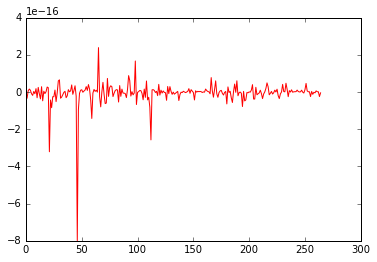

In [37]:
##plt.plot(X_test.mean(axis=0), color ="b")
plt.plot(X_train.mean(axis=0), color ="r")
plt.show()
#X_test.mean(axis=0)

In [ ]:
#plt.plot(X_test.mean(axis=0), color ="b")
plt.plot(X_train.mean(axis=0), color ="r")
plt.show()
#X_test.mean(axis=0)

In [9]:
## Feature selection

clf = ExtraTreesClassifier()
clf = clf.fit(X_train, y_train)
feature_selected = clf.feature_importances_

print ("ExtraTrees done")

feature_selected = np.argsort(-feature_selected)
print (feature_selected[0:30])

##   [305   1 268 270 266 264 263 221 265 267 223 150 143 269 219 218 128 224
##    152 220  22 233 222   2  11 189  71  13  14   4]

ExtraTrees done
[251   1 220 222 218 216 215 219 184 217 221 186 181 129 182 135 117 137
  47 183 194 187 185  22   2  16   0  17  11  14]


In [10]:
## Converting cities - first column to numbers

for j in np.unique(X_train[:,0]):
    if sum(X_train[:,0]==j)>60:
        new_col = np.zeros(X_train.shape[0])
        new_col[(X_train[:,0]==j)] = 1
        X_train = np.column_stack((X_train, new_col))  

        new_col = np.zeros(X_test.shape[0])
        new_col[(X_test[:,0]==j)] = 1
        X_test = np.column_stack((X_test, new_col))  

print (X_test.shape)
print (X_train.shape)

(75818, 268)
(76020, 268)


In [11]:
def count_zeros(a):
    return sum(a==0)

# first select columns which are biased to zeroes:

tt = np.apply_along_axis(count_zeros, 0, X_train)
sel_cols = (tt > X_train.shape[0]*0.999)
print "count columns: ", sum(sel_cols)
print (X_train.shape[0]-X_train.shape[0]*0.999)

# calculate number of zeroes in this columns

tt = np.apply_along_axis(count_zeros, 1, X_train[:,sel_cols])
X_train = np.column_stack((X_train, tt)) 

tt = np.apply_along_axis(count_zeros, 1, X_test[:,sel_cols])
X_test = np.column_stack((X_test, tt)) 

print (X_test.shape)
print (X_train.shape)

count columns:  44
76.02
(75818, 269)
(76020, 269)


In [12]:
#  https://www.kaggle.com/c/homesite-quote-conversion/forums/t/18837/what-is-your-best-single-model-score-and-how-did-you-achieve-it
#
#  Adding log features

feat = feature_selected[0:100]

c = X_train.shape[1]

k = 0

for i in feat:
    k = k+1
    if sum(X_train[:,i]<0)==0:
        new_col = np.log(X_train[:,i]+1)
        X_train = np.column_stack((X_train, new_col))

        new_col = np.sqrt(X_train[:,i])
        X_train = np.column_stack((X_train, new_col))

        new_col = 1/(0.001 + X_train[:,i])
        X_train = np.column_stack((X_train, new_col))        
        
        
        new_col = np.log(X_test[:,i]+1)
        X_test = np.column_stack((X_test, new_col))

        new_col = np.sqrt(X_test[:,i])
        X_test = np.column_stack((X_test, new_col))

        new_col = 1/(0.001 + X_test[:,i])
        X_test = np.column_stack((X_test, new_col))      
        
        
            # classifier
#     clf = xgb.XGBClassifier(missing=np.nan, max_depth=3, n_estimators=550, learning_rate=0.03, nthread=8, subsample=0.95, colsample_bytree=0.85, seed=4242)

#     X_fit, X_eval, y_fit, y_eval = train_test_split(X_train, y_train, test_size=0.5, random_state = 84)

#     # fitting
#     #clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=[(X_eval, y_eval)])

#     clf.fit(X_fit, y_fit, early_stopping_rounds=20, eval_metric="auc", eval_set=[(X_eval, y_eval)])

#     print(k, 'Overall AUC:', roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]), roc_auc_score(y_eval, clf.predict_proba(X_eval)[:,1]))

    
print(X_test.shape)
print(X_train.shape)

(75818, 533)
(76020, 533)


In [19]:
#X_train.tofile("Data/proc_train.csv", sep=",",format="%.2f")
#X_test.tofile("Data/proc_test.csv", sep=",",format="%.2f")

np.savetxt("Data/proc_train.csv", X_train, delimiter=",",  fmt='%.3e')
np.savetxt("Data/proc_test.csv", X_test, delimiter=",",  fmt='%.3e')